In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input,Bidirectional
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from gensim.models import Word2Vec
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
import os
import re

In [10]:
# 允许行内渲染图形
%matplotlib inline
## 输出高清图像
%config InlineBackend.figure_format = 'retina'

In [11]:
# 正则表达式
def clean_text(doc):
    doc = doc.replace(b"<br />", b" ")  # 替换换行符
    doc = re.sub(b"<.*?>", b" ", doc)  # 移除 HTML 标签
    doc = re.sub(b"[^\w\s]", b" ", doc)  # 移除标点符号
    doc = re.sub(b"\d+", b" ", doc)  # 移除数字
    doc = re.sub(b"\s+", b" ", doc).strip()  # 移除多余空格
    return doc

In [12]:
reviews_train = load_files("data/aclImdb/train/")
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
text_train = [clean_text(doc) for doc in text_train]

In [13]:
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
text_test = [clean_text(doc) for doc in text_test]

In [14]:
# 将字节对象转换为字符串
text_train = [doc.decode('utf-8') for doc in text_train]

In [15]:
# 将字节对象转换为字符串
text_test = [doc.decode('utf-8') for doc in text_test]

In [16]:
# 1. 生成 Word2Vec 词向量
sentences = [doc.split() for doc in text_train]  # 假设每个文本都已分词
word2vec_model = Word2Vec(sentences, vector_size=128, window=5, min_count=1, sg=1)  # 使用 Skip-gram 模型

# 2. 将文本转换为序列
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(text_train)
X_train_seq = tokenizer.texts_to_sequences(text_train)
X_test_seq = tokenizer.texts_to_sequences(text_test)

# 3. 填充序列
max_length = 200
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# 4. 构建词向量矩阵
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 128))  # 词向量维度为128
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [19]:
# 保存 tokenizer
joblib.dump(tokenizer, 'models2/tokenizer.joblib')

['models2/tokenizer.joblib']

In [21]:
# 加载 tokenizer
tokenizer = joblib.load('models2/tokenizer.joblib')

In [28]:
# 5. 构建 LSTM 模型
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, weights=[embedding_matrix], input_length=max_length, trainable=False))
# model.add(LSTM(64))
model.add(Bidirectional(LSTM(64))) # 双向LSTM，捕捉更多信息
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 6. 拟合模型
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)

# 7. 测试模型
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy}")


Epoch 1/10
625/625 [==============================] - 37s 56ms/step - loss: 0.6306 - accuracy: 0.6511 - val_loss: 0.5847 - val_accuracy: 0.6882
Epoch 2/10
625/625 [==============================] - 33s 53ms/step - loss: 0.4838 - accuracy: 0.7821 - val_loss: 0.4221 - val_accuracy: 0.8222
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 0.3523 - accuracy: 0.8528 - val_loss: 0.3304 - val_accuracy: 0.8634
Epoch 4/10
625/625 [==============================] - 34s 54ms/step - loss: 0.3164 - accuracy: 0.8692 - val_loss: 0.3105 - val_accuracy: 0.8700
Epoch 5/10
625/625 [==============================] - 36s 58ms/step - loss: 0.3034 - accuracy: 0.8749 - val_loss: 0.3003 - val_accuracy: 0.8694
Epoch 6/10
625/625 [==============================] - 36s 58ms/step - loss: 0.2926 - accuracy: 0.8794 - val_loss: 0.2844 - val_accuracy: 0.8826
Epoch 7/10
625/625 [==============================] - 36s 58ms/step - loss: 0.2802 - accuracy: 0.8847 - val_loss: 0.2785 - val_accuracy:

In [ ]:
# 保存模型
model.save("lstm_model.h5")

In [24]:
from sci_plt import *

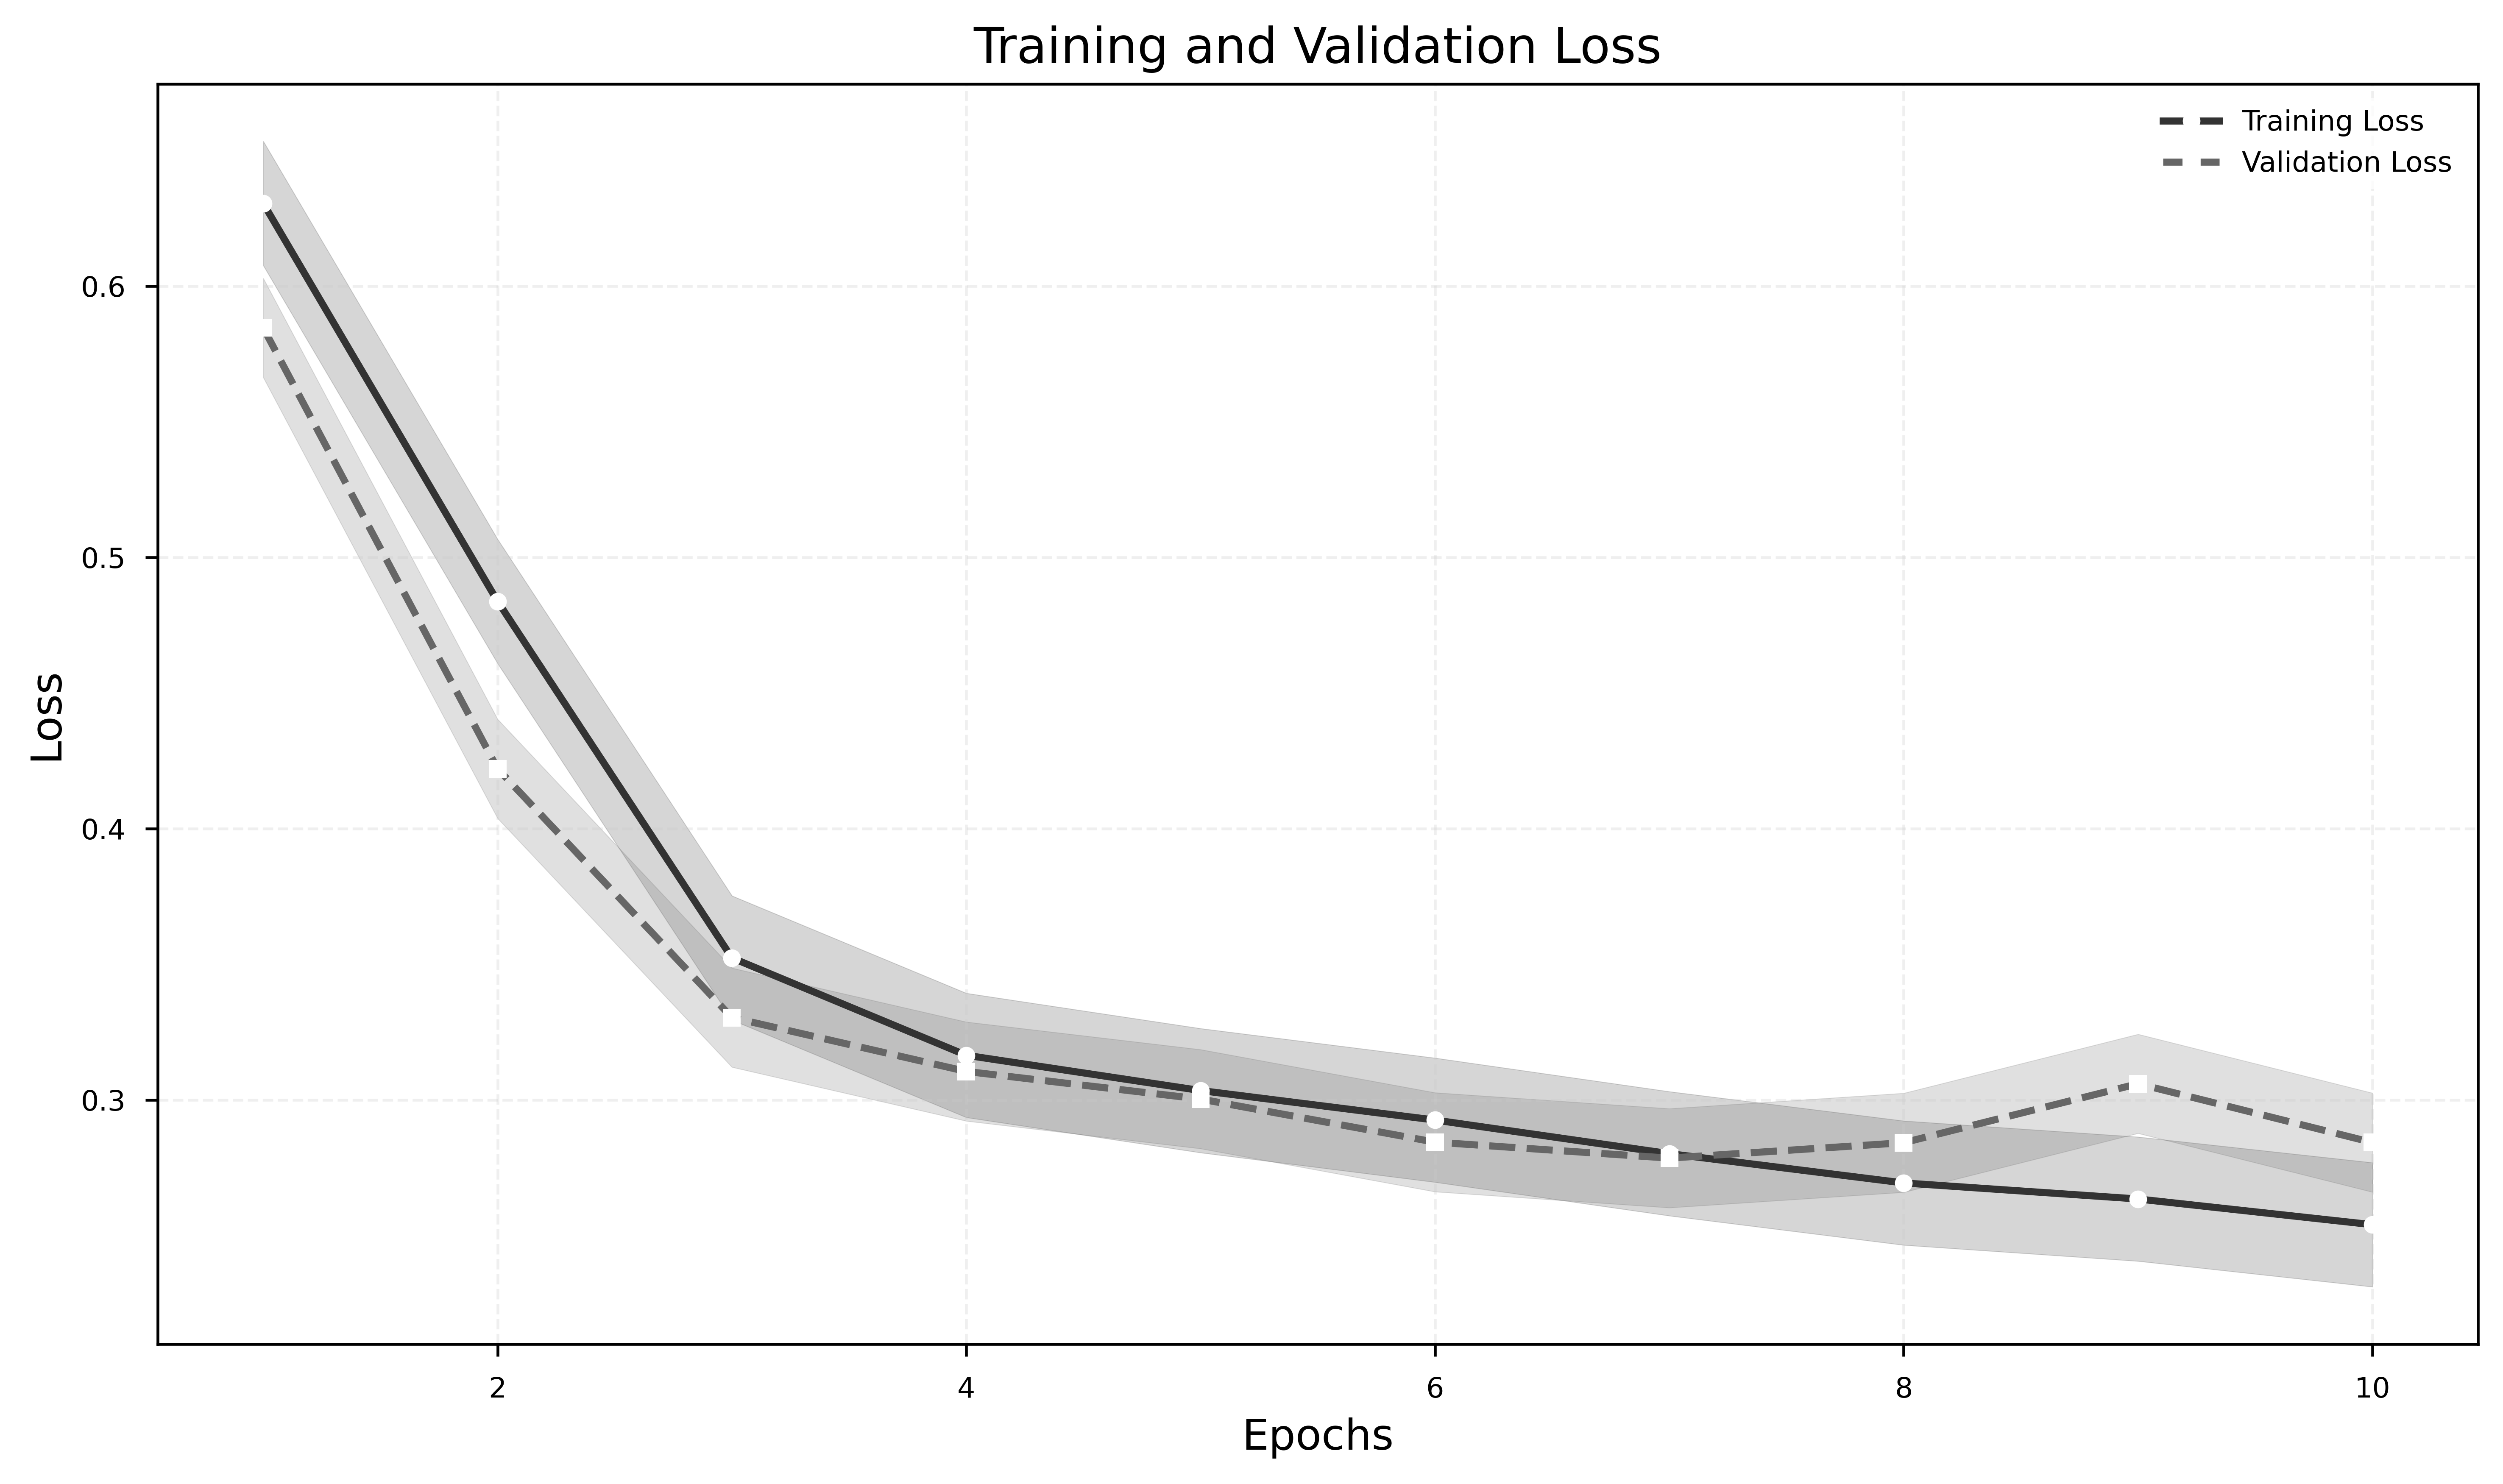

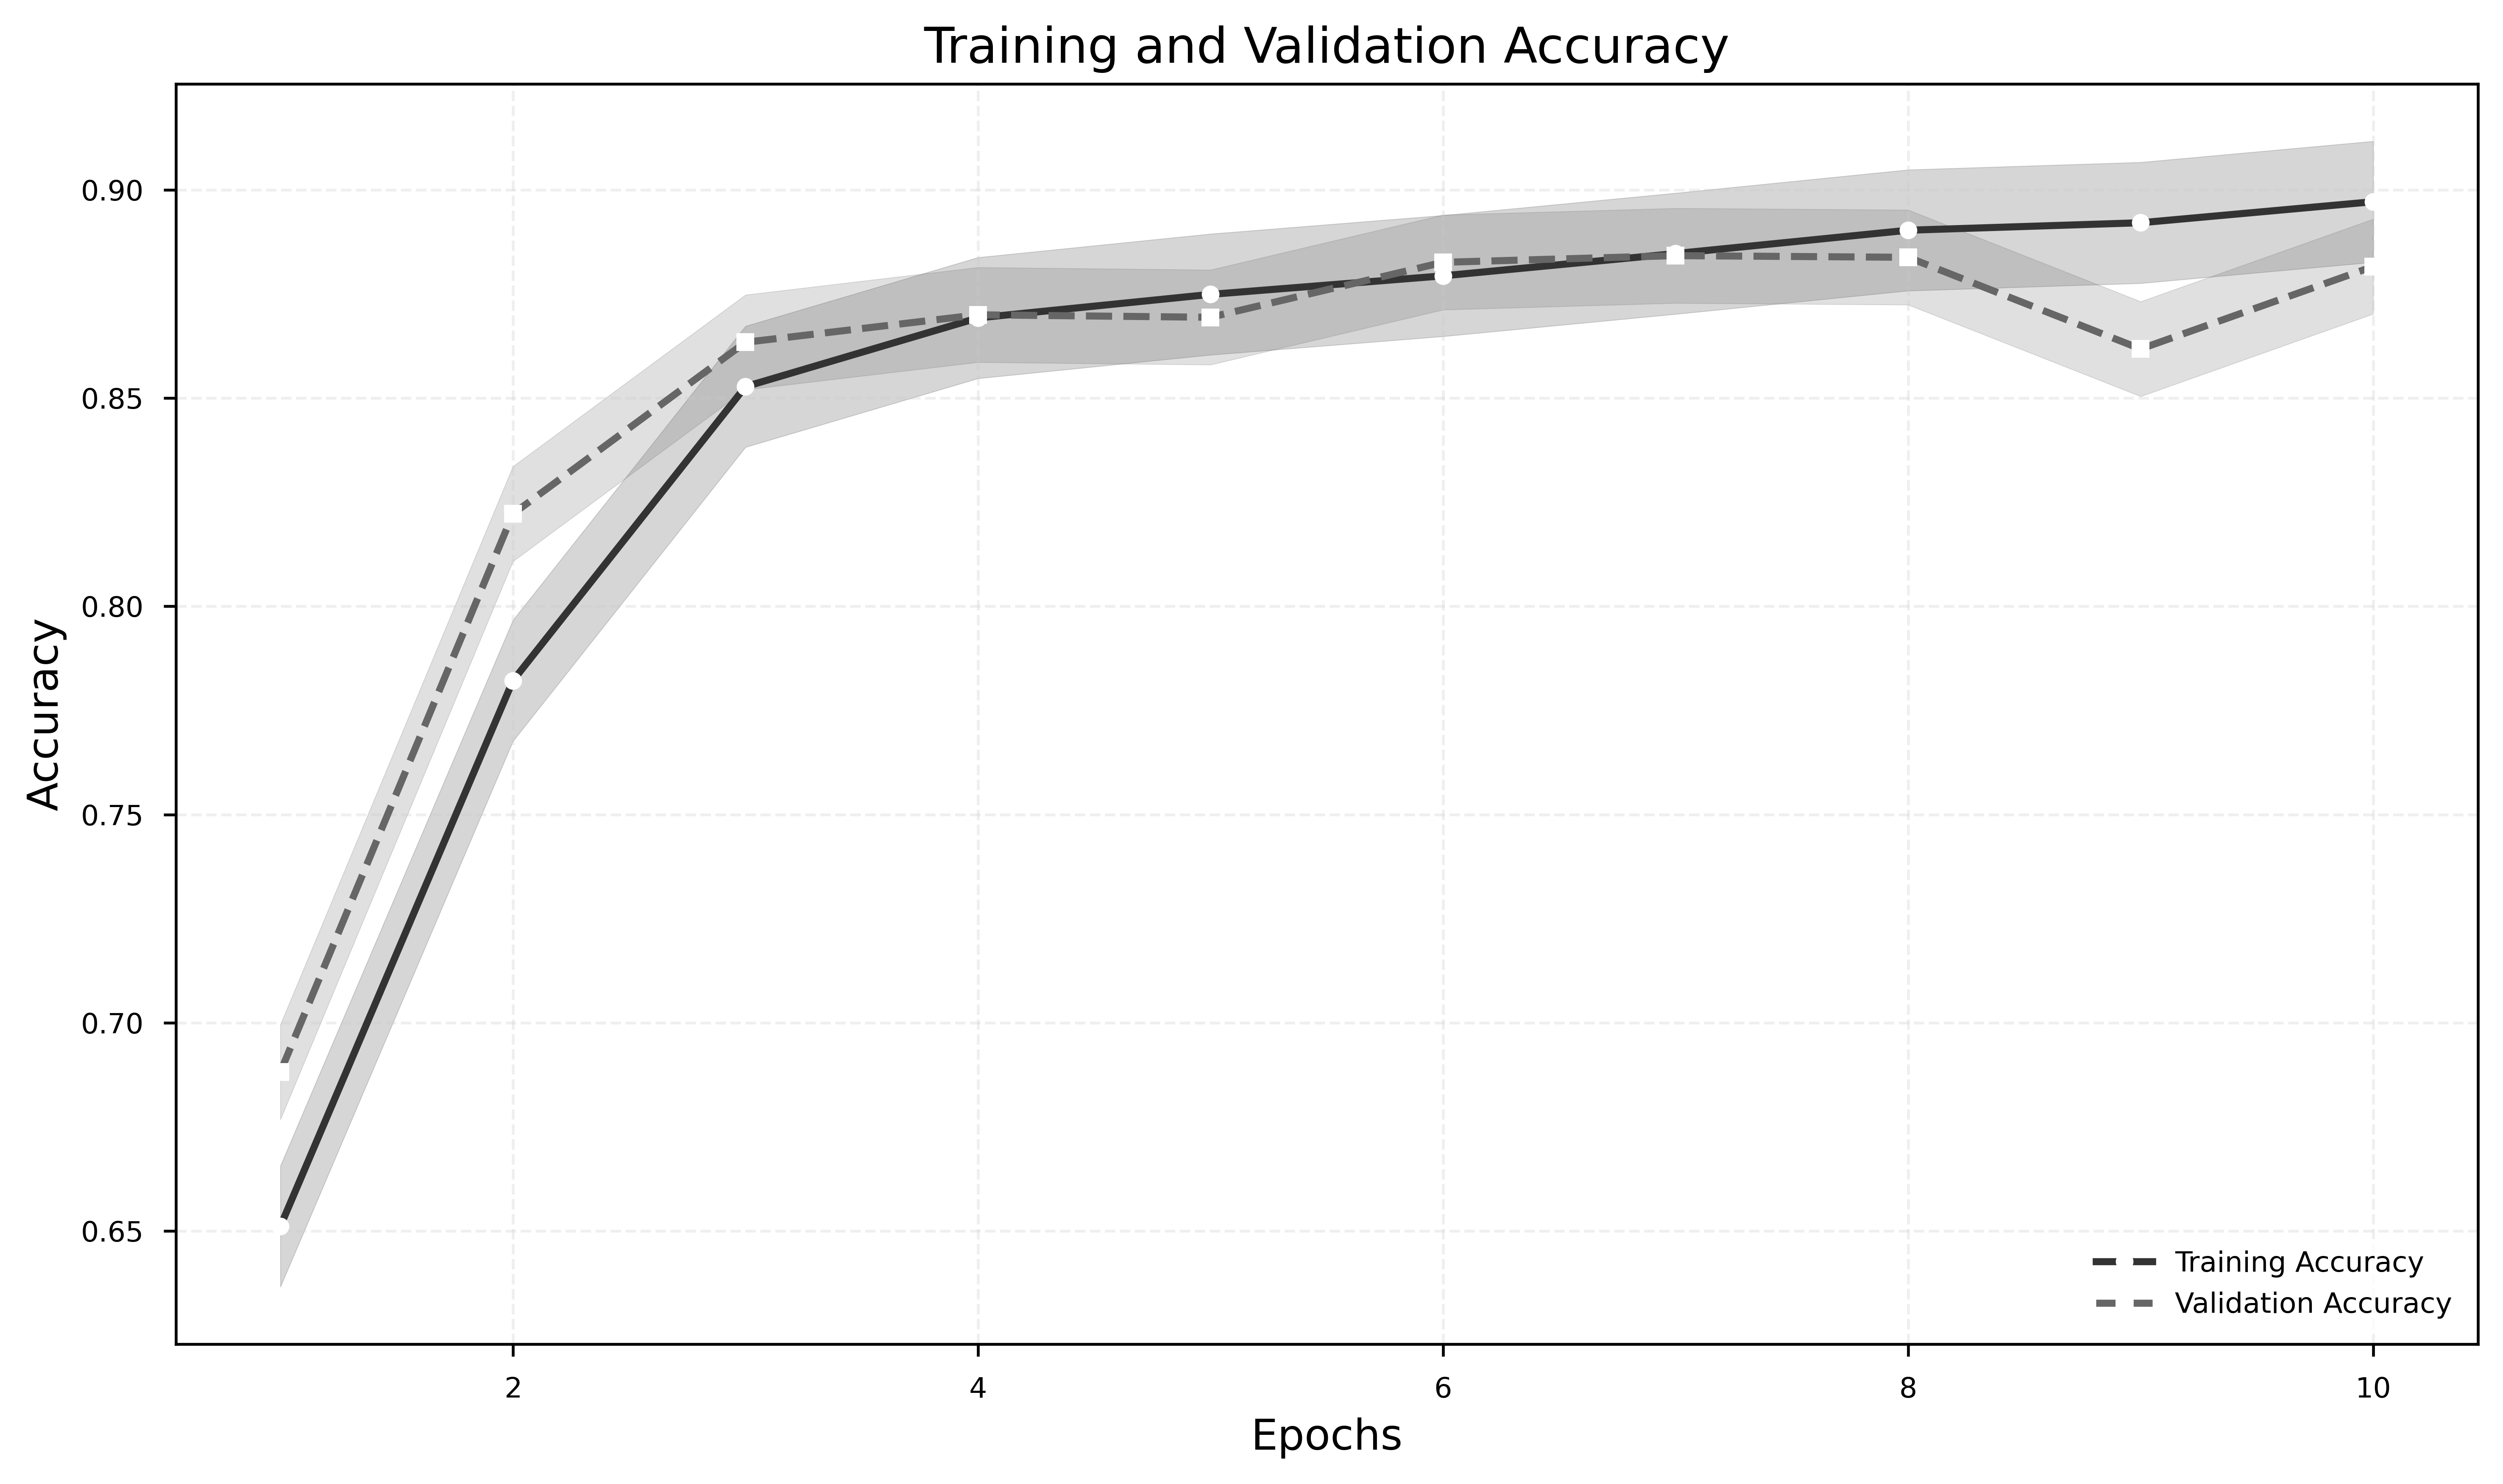

In [29]:
plot_history(history)

In [22]:
# 加载保存的模型
model = load_model("models2/lstm_model.h5")

In [23]:
# 准备测试文本
test_texts = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

# 将测试文本转换为序列
test_texts_seq = tokenizer.texts_to_sequences(test_texts)

# 填充序列
test_texts_padded = pad_sequences(test_texts_seq, maxlen=max_length)

# 预测
predictions = model.predict(test_texts_padded)

# 输出结果
for text, pred in zip(test_texts, predictions):
    sentiment = "Positive" if pred >= 0.5 else "Negative"
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment} (Score: {pred[0]:.4f})")
    print("-" * 50)


1/1 [==============================] - 0s 491ms/step
Text: this is such an amazing movie!
Predicted Sentiment: Positive (Score: 0.9559)
--------------------------------------------------
Text: The movie was great!
Predicted Sentiment: Positive (Score: 0.7187)
--------------------------------------------------
Text: The movie was meh.
Predicted Sentiment: Negative (Score: 0.4529)
--------------------------------------------------
Text: The movie was okish.
Predicted Sentiment: Negative (Score: 0.4529)
--------------------------------------------------
Text: The movie was terrible...
Predicted Sentiment: Negative (Score: 0.1199)
--------------------------------------------------
